In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import psycopg2
from sqlalchemy import create_engine
import os

### Datasets import and export

In [2]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')
x_test_add = pd.read_csv('additional_x_files_2EHFvuq/x_test_additional_file.csv')
x_train_add = pd.read_csv('additional_x_files_2EHFvuq/x_train_additional_file.csv')

In [3]:
x_train.head()

,emergency vehicle selection,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,...,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
0,5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
1,4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2
2,5365374,13675521,3,2163,0,2,139.0,2.258328,48.836759,4509,...,1981,0,2.272944,48.850498,33.0,"2.272972,48.850498;2.269056,48.847443;2.262611...",2018-11-16 10:14:31;2018-11-16 10:15:43;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""_cdiHo}zLm...",3026.4,295.4
3,4741586,12695745,3,2162,0,0,136.0,2.393832,48.776526,5731,...,1842,1,2.388940,48.787732,NaN,"2.394278,48.782112;2.393639,48.776833",2018-01-15 00:42:46;2018-01-15 00:43:58,"{""code"":""Ok"",""routes"":[{""geometry"":""sywhH_pqMy...",1934.2,166.6
4,5381209,13698743,3,2162,0,3,104.0,2.458610,48.875751,5623,...,2716,1,2.439331,48.863814,NaN,"2.439472,48.863724;2.439583,48.863777;2.440917...",2018-11-24 00:37:10;2018-11-24 00:38:22;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""wvfiHgn{Mj...",2706.7,262.6


In [6]:
# Establishing the connection with pgsql database

conn = psycopg2.connect(os.environ['DB_POMPIERS_URL'])
cur = conn.cursor()

In [ ]:
# Exporting the data into the local database

cur.execute('CREATE SCHEMA IF NOT EXISTS data')
conn.commit()

for df in ['x_train', 'y_train', 'x_test', 'x_train_add', 'x_test_add']:
    

In [17]:
def to_table_key(s): return (s.replace(' ','_').replace('-','_')).lower()
def to_exportable_df(df):
    old_cols = df.columns.tolist()
    new_cols = map(lambda x: to_table_key(x), old_cols)
    d_chcols = {k:v for (k,v) in zip(old_cols, new_cols)}
    return d_chcols

def export_df(df, name, schema="data"):
    df = df.rename(columns=to_exportable_df(df))
    engine = create_engine(os.environ['DB_POMPIERS_URL'])
    df.to_sql(name, engine, schema, if_exists='replace', index=False)

In [ ]:
# Normalization of the dfs names

x_train = x_train.rename(columns=to_exportable_df(x_train))
x_test = x_test.rename(columns=to_exportable_df(x_test))
y_train = y_train.rename(columns=to_exportable_df(y_train))
x_test_add = x_test_add.rename(columns=to_exportable_df(x_test_add))
x_train_add = x_train_add.rename(columns=to_exportable_df(x_train_add))

In [36]:
# Tests if the features names written in features.csv
# match with the ones provided in the training files

features = pd.read_csv('features.csv', sep=';')
l1 = x_train.columns.tolist()+y_train.columns.tolist()+x_train_add.columns.tolist()
l2 = features['feature_name'].tolist()
test = [(feat1==feat2, feat1, feat2) for (feat1, feat2) in zip(l1, l2) if feat1 != feat2]
print(len(test)==0)

True


### Starter code provided by the challenge organizer

In [274]:


# Data reading

x_train_transit = x_train[['OSRM estimated distance','intervention on public roads','floor']]
y_train_transit = y_train[['delta departure-presentation']]
x_test_transit = x_test[['OSRM estimated distance','intervention on public roads','floor']]

# Create a predictive model for the 'delta departure-presentation'
# based on 'OSRM estimated distance', 'intervention on public roads' and 'floor'
polynomial_features= PolynomialFeatures(degree=3)
x_train_transit_poly = polynomial_features.fit_transform(x_train_transit)
model = LinearRegression()
model.fit(x_train_transit_poly, y_train_transit)

# Prediction of the 'delta selection-presentation'
x_test_transit_poly = polynomial_features.fit_transform(x_test_transit)
y_selection_presentation_predicted = y_train['delta selection-departure'].median() + model.predict(x_test_transit_poly)

# Create a submission file
submission = pd.concat([pd.DataFrame(x_test[['emergency vehicle selection']].values), 
           pd.DataFrame(np.full((len(x_test), 1), y_train['delta selection-departure'].median())), 
           pd.DataFrame(model.predict(x_test_transit_poly)), 
           pd.DataFrame(y_selection_presentation_predicted)], 
           axis=1)

submission.columns = list(y_train.columns.values)

submission.set_index('emergency vehicle selection', inplace=True)

submission.to_csv('./submission.csv', sep=",")



[]

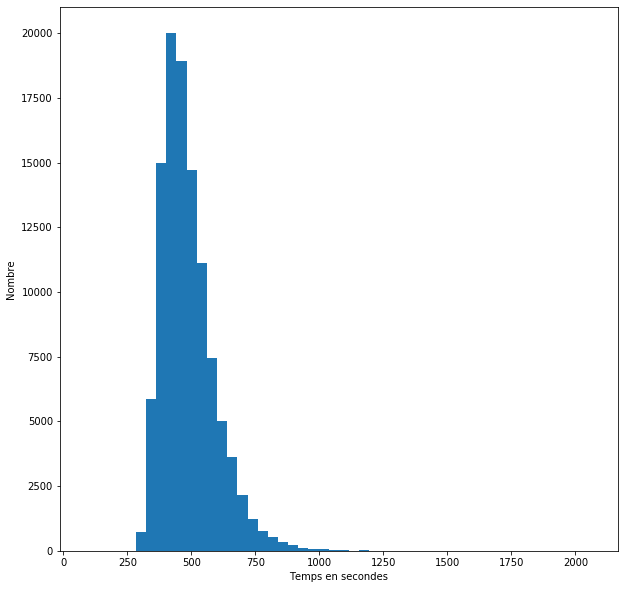

In [275]:
f, ax = plt.subplots(figsize=(10,10))
plt.hist(y_selection_presentation_predicted, bins=50)
plt.xlabel('Temps en secondes')
plt.ylabel('Nombre ')
plt.plot()

### Generation of a map for itineraries dataviz

In [271]:
import json
import requests
import polyline, geojson
from pprint import pprint
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoJSON, Polyline, CircleMarker
from geojson import LineString, Point, Feature
from ipywidgets import Layout
defaultLayout=Layout(width='960px', height='800px')

# Takes an address located in France (str)
# Returns its coordinates ['lon', 'lat']
def geocode(address, lon=2.352222, lat=48.856613, tp="housenumber"):
    add = address.replace(' ','+').lower()
    url = "https://api-adresse.data.gouv.fr/search/?q={ADD}&lat={LAT}&lon={LON}&type={TP}&limit=1".format(
        ADD=add, LAT=lat, LON=lon, TP=tp)
    response = requests.get(url)
    return json.loads(response.text)['features'][0]['geometry']['coordinates']

# Takes two lists of coordinates of points located in Paris area ([float, float], [float, float])
# Returns the Polyline route of the fastest track calculated by ORSM (Polyline)
def route(lonlat1, lonlat2=[2.352222, 48.856613], how='car'):
    base_url = "http://0.0.0.0:5000/route/v1/{HOW}/".format(HOW=how)
    url = base_url+str(lonlat1[0])+","+str(lonlat1[1])+";"+str(lonlat2[0])+","+str(lonlat2[1])
    response = requests.get(url)
    return json.loads(response.text)['routes'][0]['geometry']

# Returns a customized ipyleaflet CircleMarker
def cmarker(color="#0033FF", location=[0,0], radius=10, stroke=True, opacity=1.0, weight=5, fill=True,
            fill_color="#0033FF", fill_opacity=0.2):
    c = CircleMarker()
    c.color = color
    c.location = location
    c.radius = radius
    c.stroke = stroke
    c.opacity = opacity
    c.weight = weight
    c.fill = fill
    c.fill_color = fill_color
    c.fill_opacity = fill_opacity
    return c

# Takes two locations located in Paris area (str, str)
# Returns a map centered on the departure address with the plot of the fastest route
def gps_track(departure, destination, lonlat_inputs=False):
    if not lonlat_inputs:
        lonlat1 = geocode(departure)
        lonlat2 = geocode(destination)
    else:
        lonlat1 = departure
        lonlat2 = destination
    track = polyline.decode(route(lonlat1, lonlat2), geojson=True)
    line = GeoJSON(data=LineString(track), style = {'color': 'blue', 'opacity':0.6, 'weight':5, 'fillOpacity':0.1})
    m = Map(layers=(basemap_to_tiles(basemaps.Hydda.Full, "2019-11-19"),),
            layout=defaultLayout,
            center=(lonlat1[1], lonlat1[0]),
            zoom=14)
    m.add_layer(line)
    pt_departure = cmarker(color="#4abd0b", fill_color="#4abd0b", location=lonlat1[::-1], radius=10, weight=2)
    pt_destination = cmarker(color="#de0000", fill_color="#de0000", location=lonlat2[::-1], radius=10, weight=2)
    m.add_layer(pt_departure)
    m.add_layer(pt_destination)    
    return m

months = {'01': 'january', '02': 'february', '03': 'march', '04': 'april', '05': 'may', '06': 'june',
         '07': 'july', '08': 'august', '09': 'september', '10': 'october', '11': 'november', '12': 'december'}

In [272]:
# Takes a vehicle id of the testing dataset and plots its true and predicted itinerary
def visualize_intervention(vid):
    x = x_train.loc[x_train['emergency vehicle selection']==vid].iloc[0].to_dict()
    y = y_train.loc[y_train['emergency vehicle selection']==vid].iloc[0].to_dict()
    
    # Getting travel information
    date = str(x['date key sélection'])
    time = str(x['time key sélection'])
    time = (6-len(time))*'0'+time
    
    print("Visualization of intervention n°{VID}".format(VID=vid))
    print("{DD} {MM} {YYYY}, {HH}:{MT}:{SS}".format(DD=date[6:], MM=months[date[4:6]].capitalize(), YYYY=date[:4],
                                                   HH=time[:2], MT=time[2:4], SS=time[4:]))
    print("--------------------------------------------------------------------------")
    print("Estimated distance :", x['OSRM estimated distance'])
    print("Estimated transit duration :", x['OSRM estimated duration'])
    print("Actual transit duration :", y['delta departure-presentation'])
    print("Actual total duration :", y['delta selection-presentation'])
    
    # Retrieving tracks
    est_track = polyline.decode(eval(x['OSRM response'])['routes'][0]['geometry'], geojson=True)
    try:
        true_track = list(map(lambda l: (float(l.split(',')[0]), float(l.split(',')[1])),
                              x['GPS tracks departure-presentation'].split(';')))
    except AttributeError:
        true_track = []
        print("--------------------------------------------------------------------------")
        print("No GPS track was recorded for this intervention")
    
    dept=[x['latitude before departure'], x['longitude before departure']]
    dest=[x['latitude intervention'], x['longitude intervention']]

    # Generating layers
    est_line = GeoJSON(data=LineString(est_track),
                       style = {'color': 'purple', 'opacity':0.6, 'weight':5,'dashArray':7, 'fillOpacity':0.1})
    true_line = GeoJSON(data=LineString(true_track),
                       style = {'color': 'blue', 'opacity':0.6, 'weight':5, 'fillOpacity':0.1})
    
    pt_departure = cmarker(color="#4abd0b", fill_color="#4abd0b", location=dept, radius=10, weight=2)
    pt_destination = cmarker(color="#de0000", fill_color="#de0000", location=dest, radius=10, weight=2)
    
    # Generating map and adding layers
    m = Map(layers=(basemap_to_tiles(basemaps.Hydda.Full, "2019-11-19"),),
                layout=defaultLayout,
                center=dept,
                zoom=14)
    m.add_layer(est_line)
    m.add_layer(true_line)
    m.add_layer(pt_departure)
    m.add_layer(pt_destination)  
    
    return m

In [273]:
from random import randint
from collections import Counter

# Plot a random selection among x_train entries that have a recorded GPS track
vids = x_train.loc[~pd.isna(x_train['GPS tracks departure-presentation'])]['emergency vehicle selection'].to_list()
i = vids[randint(0, len(vids)-1)]

visualize_intervention(i)

Visualization of intervention n°4869741
18 March 2018, 21:31:29
--------------------------------------------------------------------------
Estimated distance : 1004.6
Estimated transit duration : 142.9
Actual transit duration : 189
Actual total duration : 251


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Other pieces of code

This function is not directly related to this project. Its purpose is to geocode addresses located in Quebec (Canada) to use the routing functionalities in this country. I just made it for fun!
> To use it, just replace the geocode function by the one below in gps_track()

In [ ]:
# Takes an address located in Quebec (str)
def geocode_qc(address):
    add = address.replace(' ','+').lower()
    url = "https://geocoder.ca/?locate={ADD}&json=1".format(ADD=add)
    response = requests.get(url)
    return [json.loads(response.text)["longt"],json.loads(response.text)["latt"]]